# A simple VAE


## Library imports
The following code contains the required libraries for the notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid


import torchbearer
import torchbearer.callbacks as callbacks
from torchbearer import Trial, state_key
MU = state_key('mu')
LOGVAR = state_key('logvar')

#import ...


## MNIST

In [3]:
#MNIST Settings
#classes = [0, 1, 4, 9]
batch_size = 64
eval_batch_size = 100

In [10]:
#MNIST Import
#source 7.1 autoencoder lab
from torchvision.datasets import MNIST

# transforms into tensor, can be extend
transformations = transforms.Compose([transforms.ToTensor()]) 


# Define the train and test sets
train_data = MNIST("./", train=True,  transform=transformations, download=True)
test_data  = MNIST("./", train=False, transform=transformations)


#def stratified_sampler(labels):
#    """Sampler that only picks datapoints corresponding to the specified classes"""
#    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
#    indices = torch.from_numpy(indices)
#    return SubsetRandomSampler(indices)

#load the datasets into DataLoader classes, sampler removed!
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=eval_batch_size)


## Fashion MNIST

In [5]:
from torchvision.datasets import FashionMNIST





## The Model 

inspired by: https://www.kaggle.com/ethanwharris/fashion-mnist-vae-with-pytorch-and-torchbearer

In [43]:
#Settings
latent_size = 5
learning_rate = 1e-3
num_epochs = 20

In [44]:
conv1 = (1, 32, 4, 1, 2)
conv2 = (conv1[1], 32, 4, 2, 1)
conv3 = (conv2[1], 64, 4, 2, 1)


##Look at 7.2 to see how to make encoder and decoder take non-fixed size image. 

class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super(VariationalAutoEncoder,self).__init__()
        self.latent_size = latent_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=conv1[0],out_channels=conv1[1],kernel_size=conv1[2],stride=conv1[3],padding=conv1[4]),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=conv2[0],out_channels=conv2[1],kernel_size=conv2[2],stride=conv2[3],padding=conv2[4]),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=conv3[0],out_channels=conv3[1],kernel_size=conv3[2],stride=conv3[3],padding=conv3[4]),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=conv3[1],out_channels=conv3[0],kernel_size=conv3[2],stride=conv3[3],padding=conv3[4]),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=conv2[1],out_channels=conv2[0],kernel_size=conv2[2],stride=conv2[3],padding=conv2[4],output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=conv1[1],out_channels=conv1[0],kernel_size=conv1[2],stride=conv1[3],padding=conv1[4]),
            )
        
        self.mu = nn.Linear(64 * 7 * 7, latent_size)
        self.logvar = nn.Linear(64 * 7 * 7, latent_size)
        
        self.upsample = nn.Linear(latent_size, 64*7*7)
        
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x, state):
        image = x
        x = self.encoder(x).relu().view(x.size(0), -1)
        
        mu = self.mu(x)
        logvar = self.logvar(x)
        sample = self.reparameterize(mu, logvar)
        
        result = self.decoder(self.upsample(sample).relu().view(-1, 64, 7, 7))
        
        if state is not None:
            state[torchbearer.Y_TRUE] = image
            state[MU] = mu
            state[LOGVAR] = logvar
                  
        return result
     
print(VariationalAutoEncoder(latent_size=latent_size))

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
  (mu): Linear(in_features=3136, out_features=5, bias=True)
  (logvar): Linear(in_features=3136, out_features=5, bias=True)
  (upsample): Linear(in_features=5, out_features=3136, bias=True)
)


### KL

In [45]:
def beta_kl(mu_key, logvar_key, beta=5):
    #@callbacks.add_to_loss
    def callback(state):
        mu = state[mu_key]
        logvar = state[logvar_key]
        return -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta
    
    return callback

### Visualisation

In [46]:
def plot_progress(key=torchbearer.Y_PRED, num_images=100, nrow=10):
    #@callbacks.on_step_validation
    #@callbacks.once_per_epoch
    def callback(state):
        images = state[key]
        image = make_grid(images[:num_images], nrow=nrow, normalize=True)[0, :, :]
        plt.imshow(image.detach().cpu().numpy(), cmap="gray")
        plt.show()
    
    return callback

### Training

In [ ]:
vae = VariationalAutoEncoder(latent_size=latent_size)
optimizer = optim.Adam(vae.parameters(),lr=learning_rate)



### Training (with torchbearer)

0/5(t): loss=0.0729, mse=0.0693, running_loss=0.0679, running_mse=0.0679
1/5(t): loss=0.0678, mse=0.0678, running_loss=0.0676, running_mse=0.0676
2/5(t): loss=0.0677, mse=0.0677, running_loss=0.0675, running_mse=0.0675
3/5(t): loss=0.0676, mse=0.0676, running_loss=0.0674, running_mse=0.0673
4/5(t): loss=0.0676, mse=0.0676, running_loss=0.0673, running_mse=0.0673

0/1(v): 0/100 

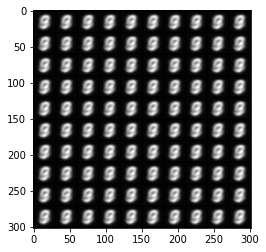

0/1(v): test_loss=0.0678, test_mse=0.0678


{'test_mse': 0.06776216626167297, 'test_loss': 0.06777298450469971}

In [47]:
vae = VariationalAutoEncoder(latent_size=latent_size)
optimizer = optim.Adam(vae.parameters(),lr=learning_rate)
trial = Trial(
    vae, 
    optimizer, 
    nn.MSELoss(reduction='mean'), metrics=['acc', 'loss'], 
    callbacks=[
        beta_kl(MU, LOGVAR),
        callbacks.ConsolePrinter(),
        plot_progress()],
    verbose=1).with_generators(train_generator=train_loader,test_generator=test_loader)
trial.to('cuda')
trial.run(5)
trial.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)

0/5(t): loss=3409.1113, mse=0.0645, running_loss=3298.9412, running_mse=0.0596
1/5(t): loss=3270.4412, mse=0.0577, running_loss=3238.2083, running_mse=0.0558
2/5(t): loss=3243.4451, mse=0.0556, running_loss=3210.8347, running_mse=0.0546
3/5(t): loss=3232.2842, mse=0.0547, running_loss=3215.3818, running_mse=0.0537
4/5(t): loss=3219.3518, mse=0.0539, running_loss=3200.6155, running_mse=0.0531

0/1(v): 0/100 

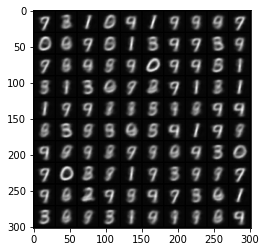

0/1(v): test_loss=4548.2188, test_mse=0.0487


{'test_mse': 0.04872538521885872, 'test_loss': 4548.21875}

In [48]:
vae = VariationalAutoEncoder(latent_size=latent_size)
optimizer = optim.Adam(vae.parameters(),lr=learning_rate)
trial = Trial(
    vae, 
    optimizer, 
    #mean-squared error or cross-entropy
    nn.MSELoss(reduction='sum'), metrics=['acc', 'loss'], 
    callbacks=[
        beta_kl(MU, LOGVAR),
        callbacks.ConsolePrinter(),
        plot_progress()],
    verbose=1).with_generators(train_generator=train_loader,test_generator=test_loader)
trial.to('cuda')
trial.run(5)
trial.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)